In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# settings
import warnings
warnings.filterwarnings("ignore")

In [2]:
path = os.getenv("HOME") + '/aiffel/predict_future_sales'

In [3]:
items = pd.read_csv(path + '/items.csv')
items.head()

item_name  item_id  \
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1  !ABBYY FineReader 12 Professional Edition Full...        1   
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   
3    ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        3   
4        ***КОРОБКА (СТЕКЛО)                       D        4   

   item_category_id  
0                40  
1                76  
2                40  
3                40  
4                40

In [4]:
categories = pd.read_csv(path + '/item_categories.csv')
categories.head()

item_category_name  item_category_id
0  PC - Гарнитуры/Наушники                 0
1         Аксессуары - PS2                 1
2         Аксессуары - PS3                 2
3         Аксессуары - PS4                 3
4         Аксессуары - PSP                 4

In [5]:
shops = pd.read_csv(path + '/shops.csv')
shops.head()

shop_name  shop_id
0   !Якутск Орджоникидзе, 56 фран        0
1   !Якутск ТЦ "Центральный" фран        1
2                Адыгея ТЦ "Мега"        2
3  Балашиха ТРК "Октябрь-Киномир"        3
4        Волжский ТЦ "Волга Молл"        4

In [6]:
test = pd.read_csv(path + '/test.csv')
test.head()

ID  shop_id  item_id
0   0        5     5037
1   1        5     5320
2   2        5     5233
3   3        5     5232
4   4        5     5268

In [7]:
train = pd.read_csv(path + '/sales_train.csv')
train.head()

date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0

## Train 데이터 전처리

<AxesSubplot:>

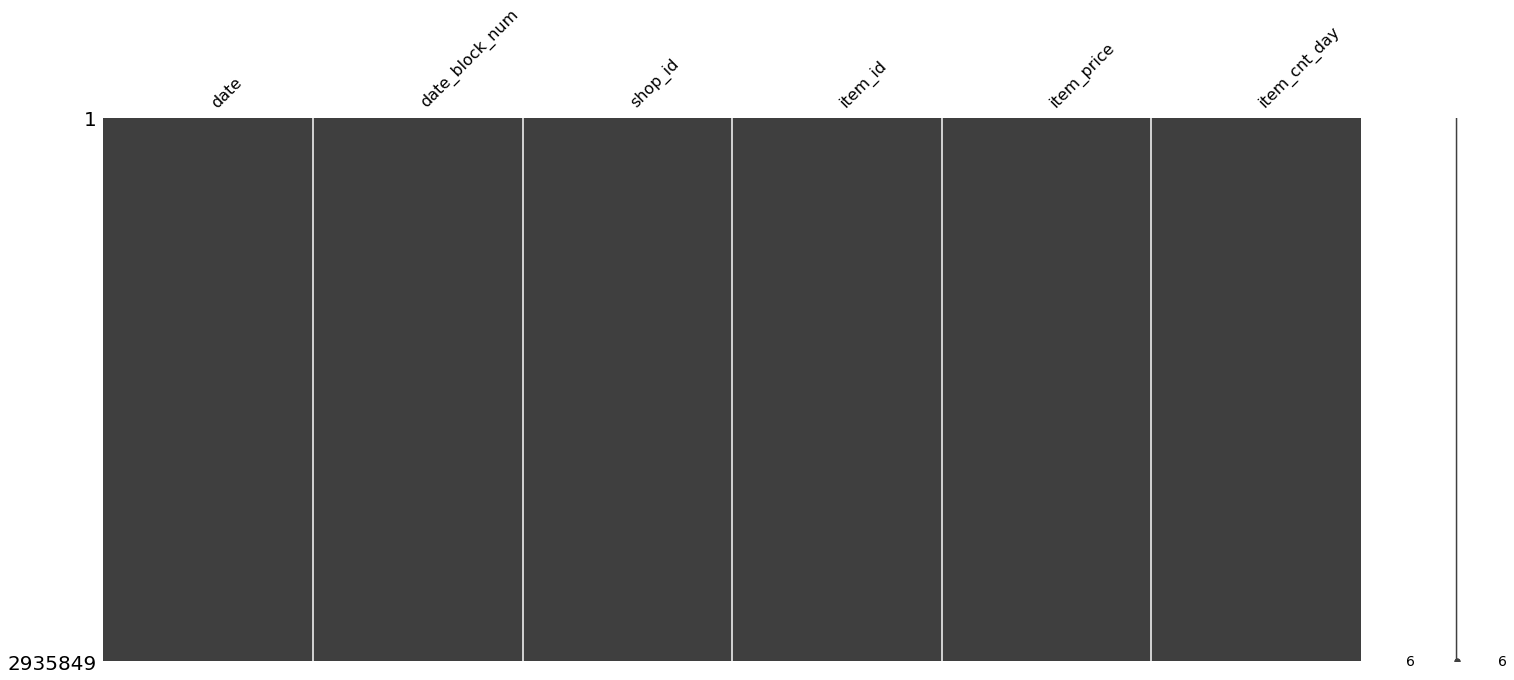

In [8]:
import missingno as msno
# 결측치 확인
msno.matrix(train)

In [9]:
# monthly_sales=train.groupby(["date_block_num","shop_id","item_id"])[
#     "date","item_price","item_cnt_day"].agg({"date":["min",'max'],"item_price":"mean","item_cnt_day":"sum"})

In [10]:
# monthly_sales.head(20)

<AxesSubplot:xlabel='item_price'>

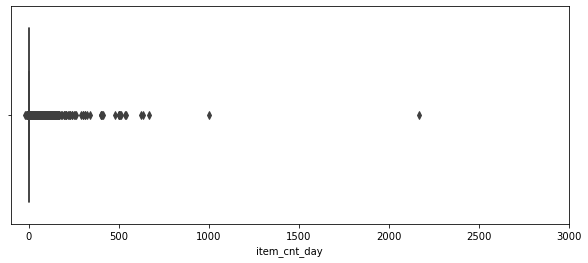

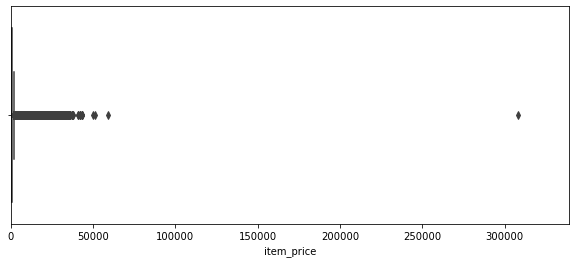

In [11]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)

In [12]:
# 아웃라이너 제거
print(len(train))
train = train[train.item_price<50000]
train = train[train.item_cnt_day<500]
len(train)

2935849


2935832

In [13]:
# 중복데이터 찾기
train[train.duplicated() == True]

date  date_block_num  shop_id  item_id  item_price  \
76962    05.01.2013               0       54    20130       149.0   
1435367  23.02.2014              13       50     3423       999.0   
1496766  23.03.2014              14       21     3423       999.0   
1671873  01.05.2014              16       50     3423       999.0   
1866340  12.07.2014              18       25     3423       999.0   
2198566  31.12.2014              23       42    21619       499.0   

         item_cnt_day  
76962             1.0  
1435367           1.0  
1496766           1.0  
1671873           1.0  
1866340           1.0  
2198566           1.0

In [14]:
# 중복데이터 제거
train.drop_duplicates(inplace=True)
train[train.duplicated() == True]

Empty DataFrame
Columns: [date, date_block_num, shop_id, item_id, item_price, item_cnt_day]
Index: []

In [15]:
# 가격이 이상한 이상치 제거
train[train['item_price'] <= 0]

date  date_block_num  shop_id  item_id  item_price  item_cnt_day
484683  15.05.2013               4       32     2973        -1.0           1.0

In [16]:
train = train[train['item_price'] > 0]
train[train['item_price'] <= 0]

Empty DataFrame
Columns: [date, date_block_num, shop_id, item_id, item_price, item_cnt_day]
Index: []

## Shops 테이블에서 city 추출

In [17]:
# shop 이름에서 도시명 분리
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.head()

shop_name  shop_id      city
0   !Якутск Орджоникидзе, 56 фран        0   !Якутск
1   !Якутск ТЦ "Центральный" фран        1   !Якутск
2                Адыгея ТЦ "Мега"        2    Адыгея
3  Балашиха ТРК "Октябрь-Киномир"        3  Балашиха
4        Волжский ТЦ "Волга Молл"        4  Волжский

In [18]:
city_li = shops['city'].unique()
city_li

array(['!Якутск', 'Адыгея', 'Балашиха', 'Волжский', 'Вологда', 'Воронеж',
       'Выездная', 'Жуковский', 'Интернет-магазин', 'Казань', 'Калуга',
       'Коломна', 'Красноярск', 'Курск', 'Москва', 'Мытищи', 'Н.Новгород',
       'Новосибирск', 'Омск', 'РостовНаДону', 'СПб', 'Самара', 'Сергиев',
       'Сургут', 'Томск', 'Тюмень', 'Уфа', 'Химки', 'Цифровой', 'Чехов',
       'Якутск', 'Ярославль'], dtype=object)

In [19]:
# '!Якутск'를 'Якутск'로 변환
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
city_li = shops['city'].unique()
city_li

array(['Якутск', 'Адыгея', 'Балашиха', 'Волжский', 'Вологда', 'Воронеж',
       'Выездная', 'Жуковский', 'Интернет-магазин', 'Казань', 'Калуга',
       'Коломна', 'Красноярск', 'Курск', 'Москва', 'Мытищи', 'Н.Новгород',
       'Новосибирск', 'Омск', 'РостовНаДону', 'СПб', 'Самара', 'Сергиев',
       'Сургут', 'Томск', 'Тюмень', 'Уфа', 'Химки', 'Цифровой', 'Чехов',
       'Ярославль'], dtype=object)

In [20]:
# 인코딩
from sklearn.preprocessing import LabelEncoder
city_encoder = LabelEncoder()
shops['city_code'] = city_encoder.fit_transform(shops['city'])
shops.head()

shop_name  shop_id      city  city_code
0   !Якутск Орджоникидзе, 56 фран        0    Якутск         29
1   !Якутск ТЦ "Центральный" фран        1    Якутск         29
2                Адыгея ТЦ "Мега"        2    Адыгея          0
3  Балашиха ТРК "Октябрь-Киномир"        3  Балашиха          1
4        Волжский ТЦ "Волга Молл"        4  Волжский          2

## Item category

In [21]:
categories

item_category_name  item_category_id
0     PC - Гарнитуры/Наушники                 0
1            Аксессуары - PS2                 1
2            Аксессуары - PS3                 2
3            Аксессуары - PS4                 3
4            Аксессуары - PSP                 4
..                        ...               ...
79                  Служебные                79
80         Служебные - Билеты                80
81    Чистые носители (шпиль)                81
82  Чистые носители (штучные)                82
83           Элементы питания                83

[84 rows x 2 columns]

In [22]:
type_encoder = LabelEncoder()
categories['split_name'] = categories['item_category_name'].str.split(' - ')
categories['type'] = categories['split_name'].map(lambda x: x[0].strip())
categories['type_code'] = type_encoder.fit_transform(categories['type'])

In [23]:
categories

item_category_name  item_category_id                   split_name  \
0     PC - Гарнитуры/Наушники                 0     [PC, Гарнитуры/Наушники]   
1            Аксессуары - PS2                 1            [Аксессуары, PS2]   
2            Аксессуары - PS3                 2            [Аксессуары, PS3]   
3            Аксессуары - PS4                 3            [Аксессуары, PS4]   
4            Аксессуары - PSP                 4            [Аксессуары, PSP]   
..                        ...               ...                          ...   
79                  Служебные                79                  [Служебные]   
80         Служебные - Билеты                80          [Служебные, Билеты]   
81    Чистые носители (шпиль)                81    [Чистые носители (шпиль)]   
82  Чистые носители (штучные)                82  [Чистые носители (штучные)]   
83           Элементы питания                83           [Элементы питания]   

                         type  type_code  
0                          PC          0  
1                  Аксессуары          1  
2                  Аксессуары          1  
3                  Аксессуары          1  
4                  Аксессуары          1  
..                        ...        ...  
79                  Служебные         16  
80                  Служебные         16  
81    Чистые носители (шпиль)         17  
82  Чистые носители (штучные)         18  
83           Элементы питания         19  

[84 rows x 5 columns]

In [24]:
subtype_encoder = LabelEncoder()
categories['subtype'] = categories['split_name'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
categories['subtype_code'] = subtype_encoder.fit_transform(categories['subtype'])
categories

item_category_name  item_category_id                   split_name  \
0     PC - Гарнитуры/Наушники                 0     [PC, Гарнитуры/Наушники]   
1            Аксессуары - PS2                 1            [Аксессуары, PS2]   
2            Аксессуары - PS3                 2            [Аксессуары, PS3]   
3            Аксессуары - PS4                 3            [Аксессуары, PS4]   
4            Аксессуары - PSP                 4            [Аксессуары, PSP]   
..                        ...               ...                          ...   
79                  Служебные                79                  [Служебные]   
80         Служебные - Билеты                80          [Служебные, Билеты]   
81    Чистые носители (шпиль)                81    [Чистые носители (шпиль)]   
82  Чистые носители (штучные)                82  [Чистые носители (штучные)]   
83           Элементы питания                83           [Элементы питания]   

                         type  type_code                    subtype  \
0                          PC          0         Гарнитуры/Наушники   
1                  Аксессуары          1                        PS2   
2                  Аксессуары          1                        PS3   
3                  Аксессуары          1                        PS4   
4                  Аксессуары          1                        PSP   
..                        ...        ...                        ...   
79                  Служебные         16                  Служебные   
80                  Служебные         16                     Билеты   
81    Чистые носители (шпиль)         17    Чистые носители (шпиль)   
82  Чистые носители (штучные)         18  Чистые носители (штучные)   
83           Элементы питания         19           Элементы питания   

    subtype_code  
0             31  
1             11  
2             12  
3             13  
4             15  
..           ...  
79            56  
80            27  
81            64  
82            65  
83            66  

[84 rows x 7 columns]

In [25]:
categories = categories[['item_category_id', 'type_code', 'subtype_code']]
categories.head()

item_category_id  type_code  subtype_code
0                 0          0            31
1                 1          1            11
2                 2          1            12
3                 3          1            13
4                 4          1            15

## 데이터 테이블 하나로 합치기

In [26]:
data = train.groupby(['date_block_num', 'shop_id', 'item_id'])['item_cnt_day'].sum()
data = pd.DataFrame(data).reset_index()
data.columns = ['date_block_num', 'shop_id', 'item_id', 'item_cnt_month']
data.head()

date_block_num  shop_id  item_id  item_cnt_month
0               0        0       32             6.0
1               0        0       33             3.0
2               0        0       35             1.0
3               0        0       43             1.0
4               0        0       51             2.0

In [27]:
test = test[['shop_id', 'item_id']]
test['date_block_num'] = 34
test.head()

shop_id  item_id  date_block_num
0        5     5037              34
1        5     5320              34
2        5     5233              34
3        5     5232              34
4        5     5268              34

In [28]:
data = pd.concat([data, test], ignore_index=True, sort=False, keys=['date_block_num', 'shop_id', 'item_id'])
data.fillna(0, inplace=True) # for 34 month
data.head()

date_block_num  shop_id  item_id  item_cnt_month
0               0        0       32             6.0
1               0        0       33             3.0
2               0        0       35             1.0
3               0        0       43             1.0
4               0        0       51             2.0

In [29]:
data = pd.merge(data, shops, on=['shop_id'], how='left')
data = pd.merge(data, items, on=['item_id'], how='left')
data = pd.merge(data, categories, on=['item_category_id'], how='left')
data['city_code'] = data['city_code'].astype(np.int8)
data['item_category_id'] = data['item_category_id'].astype(np.int8)
data['type_code'] = data['type_code'].astype(np.int8)
data['subtype_code'] = data['subtype_code'].astype(np.int8)

In [30]:
data.head()

date_block_num  shop_id  item_id  item_cnt_month  \
0               0        0       32             6.0   
1               0        0       33             3.0   
2               0        0       35             1.0   
3               0        0       43             1.0   
4               0        0       51             2.0   

                       shop_name    city  city_code  \
0  !Якутск Орджоникидзе, 56 фран  Якутск         29   
1  !Якутск Орджоникидзе, 56 фран  Якутск         29   
2  !Якутск Орджоникидзе, 56 фран  Якутск         29   
3  !Якутск Орджоникидзе, 56 фран  Якутск         29   
4  !Якутск Орджоникидзе, 56 фран  Якутск         29   

                                           item_name  item_category_id  \
0                                                1+1                40   
1                                           1+1 (BD)                37   
2                                      10 ЛЕТ СПУСТЯ                40   
3                                 100 МИЛЛИОНОВ ЕВРО                40   
4  100 лучших произведений классики (mp3-CD) (Dig...                57   

   type_code  subtype_code  
0         11             6  
1         11             1  
2         11             6  
3         11             6  
4         13            10

In [31]:
base = data[['date_block_num','shop_id','item_id', 'item_cnt_month','city_code'
            ,'item_category_id', 'type_code','subtype_code']]
base.head()

date_block_num  shop_id  item_id  item_cnt_month  city_code  \
0               0        0       32             6.0         29   
1               0        0       33             3.0         29   
2               0        0       35             1.0         29   
3               0        0       43             1.0         29   
4               0        0       51             2.0         29   

   item_category_id  type_code  subtype_code  
0                40         11             6  
1                37         11             1  
2                40         11             6  
3                40         11             6  
4                57         13            10

In [32]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [33]:
base = lag_feature(base, [1,2,3,6,12], 'item_cnt_month')
base.head()

date_block_num  shop_id  item_id  item_cnt_month  city_code  \
0               0        0       32             6.0         29   
1               0        0       33             3.0         29   
2               0        0       35             1.0         29   
3               0        0       43             1.0         29   
4               0        0       51             2.0         29   

   item_category_id  type_code  subtype_code  item_cnt_month_lag_1  \
0                40         11             6                   NaN   
1                37         11             1                   NaN   
2                40         11             6                   NaN   
3                40         11             6                   NaN   
4                57         13            10                   NaN   

   item_cnt_month_lag_2  item_cnt_month_lag_3  item_cnt_month_lag_6  \
0                   NaN                   NaN                   NaN   
1                   NaN                   NaN                   NaN   
2                   NaN                   NaN                   NaN   
3                   NaN                   NaN                   NaN   
4                   NaN                   NaN                   NaN   

   item_cnt_month_lag_12  
0                    NaN  
1                    NaN  
2                    NaN  
3                    NaN  
4                    NaN

In [34]:
group = base.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_avg_item_cnt']

In [36]:
group.reset_index(inplace=True)
group.head()

date_block_num  date_avg_item_cnt
0               0           2.079558
1               1           2.137149
2               2           2.299920
3               3           1.961821
4               4           2.007074

In [37]:
base = pd.merge(base, group, on=['date_block_num'], how='left')
base['date_avg_item_cnt'] = base['date_avg_item_cnt'].astype(np.float16)
base.head()

date_block_num  shop_id  item_id  item_cnt_month  city_code  \
0               0        0       32             6.0         29   
1               0        0       33             3.0         29   
2               0        0       35             1.0         29   
3               0        0       43             1.0         29   
4               0        0       51             2.0         29   

   item_category_id  type_code  subtype_code  item_cnt_month_lag_1  \
0                40         11             6                   NaN   
1                37         11             1                   NaN   
2                40         11             6                   NaN   
3                40         11             6                   NaN   
4                57         13            10                   NaN   

   item_cnt_month_lag_2  item_cnt_month_lag_3  item_cnt_month_lag_6  \
0                   NaN                   NaN                   NaN   
1                   NaN                   NaN                   NaN   
2                   NaN                   NaN                   NaN   
3                   NaN                   NaN                   NaN   
4                   NaN                   NaN                   NaN   

   item_cnt_month_lag_12  date_avg_item_cnt  
0                    NaN           2.080078  
1                    NaN           2.080078  
2                    NaN           2.080078  
3                    NaN           2.080078  
4                    NaN           2.080078

In [38]:
base = lag_feature(base, [1], 'date_avg_item_cnt')
base.tail()

date_block_num  shop_id  item_id  item_cnt_month  city_code  \
1823314              34       45    18454             0.0         20   
1823315              34       45    16188             0.0         20   
1823316              34       45    15757             0.0         20   
1823317              34       45    19648             0.0         20   
1823318              34       45      969             0.0         20   

         item_category_id  type_code  subtype_code  item_cnt_month_lag_1  \
1823314                55         13             4                   1.0   
1823315                64         14            44                   NaN   
1823316                55         13             4                   NaN   
1823317                40         11             6                   NaN   
1823318                37         11             1                   NaN   

         item_cnt_month_lag_2  item_cnt_month_lag_3  item_cnt_month_lag_6  \
1823314                   NaN                   NaN                   NaN   
1823315                   NaN                   NaN                   NaN   
1823316                   NaN                   NaN                   NaN   
1823317                   NaN                   NaN                   NaN   
1823318                   NaN                   NaN                   NaN   

         item_cnt_month_lag_12  date_avg_item_cnt  date_avg_item_cnt_lag_1  
1823314                    NaN                0.0                 2.169922  
1823315                    NaN                0.0                      NaN  
1823316                    NaN                0.0                      NaN  
1823317                    NaN                0.0                      NaN  
1823318                    NaN                0.0                      NaN

In [39]:
base.drop(['date_avg_item_cnt'], axis=1, inplace=True)
base.tail()

date_block_num  shop_id  item_id  item_cnt_month  city_code  \
1823314              34       45    18454             0.0         20   
1823315              34       45    16188             0.0         20   
1823316              34       45    15757             0.0         20   
1823317              34       45    19648             0.0         20   
1823318              34       45      969             0.0         20   

         item_category_id  type_code  subtype_code  item_cnt_month_lag_1  \
1823314                55         13             4                   1.0   
1823315                64         14            44                   NaN   
1823316                55         13             4                   NaN   
1823317                40         11             6                   NaN   
1823318                37         11             1                   NaN   

         item_cnt_month_lag_2  item_cnt_month_lag_3  item_cnt_month_lag_6  \
1823314                   NaN                   NaN                   NaN   
1823315                   NaN                   NaN                   NaN   
1823316                   NaN                   NaN                   NaN   
1823317                   NaN                   NaN                   NaN   
1823318                   NaN                   NaN                   NaN   

         item_cnt_month_lag_12  date_avg_item_cnt_lag_1  
1823314                    NaN                 2.169922  
1823315                    NaN                      NaN  
1823316                    NaN                      NaN  
1823317                    NaN                      NaN  
1823318                    NaN                      NaN

In [42]:
# matrix에 월별 item별 평균 판매 수량(date_item_avg_item_cnt) lag 추가하기
group = base.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_item_avg_item_cnt']
group.reset_index(inplace=True)

base = pd.merge(base, group, on=['date_block_num', 'item_id'], how='left')
base['date_item_avg_item_cnt'] = base['date_item_avg_item_cnt'].astype(np.float16)
base = lag_feature(base, [1,2,3,6,12], 'date_item_avg_item_cnt')
base.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)


In [43]:
# matrix에 월별, shop_id별 평균 판매 수량(date_shop_avg_item_cnt) lag 추가하기
group = base.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_shop_avg_item_cnt' ]
group.reset_index(inplace=True)

base = pd.merge(base, group, on=['date_block_num','shop_id'], how='left')
base['date_shop_avg_item_cnt'] = base['date_shop_avg_item_cnt'].astype(np.float16)
base = lag_feature(base, [1,2,3,6,12], 'date_shop_avg_item_cnt')
base.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)

In [44]:
base.head()

date_block_num  shop_id  item_id  item_cnt_month  city_code  \
0               0        0       32             6.0         29   
1               0        0       33             3.0         29   
2               0        0       35             1.0         29   
3               0        0       43             1.0         29   
4               0        0       51             2.0         29   

   item_category_id  type_code  subtype_code  item_cnt_month_lag_1  \
0                40         11             6                   NaN   
1                37         11             1                   NaN   
2                40         11             6                   NaN   
3                40         11             6                   NaN   
4                57         13            10                   NaN   

   item_cnt_month_lag_2  ...  date_item_avg_item_cnt_lag_1  \
0                   NaN  ...                           NaN   
1                   NaN  ...                           NaN   
2                   NaN  ...                           NaN   
3                   NaN  ...                           NaN   
4                   NaN  ...                           NaN   

   date_item_avg_item_cnt_lag_2  date_item_avg_item_cnt_lag_3  \
0                           NaN                           NaN   
1                           NaN                           NaN   
2                           NaN                           NaN   
3                           NaN                           NaN   
4                           NaN                           NaN   

   date_item_avg_item_cnt_lag_6  date_item_avg_item_cnt_lag_12  \
0                           NaN                            NaN   
1                           NaN                            NaN   
2                           NaN                            NaN   
3                           NaN                            NaN   
4                           NaN                            NaN   

   date_shop_avg_item_cnt_lag_1  date_shop_avg_item_cnt_lag_2  \
0                           NaN                           NaN   
1                           NaN                           NaN   
2                           NaN                           NaN   
3                           NaN                           NaN   
4                           NaN                           NaN   

   date_shop_avg_item_cnt_lag_3  date_shop_avg_item_cnt_lag_6  \
0                           NaN                           NaN   
1                           NaN                           NaN   
2                           NaN                           NaN   
3                           NaN                           NaN   
4                           NaN                           NaN   

   date_shop_avg_item_cnt_lag_12  
0                            NaN  
1                            NaN  
2                            NaN  
3                            NaN  
4                            NaN  

[5 rows x 24 columns]

In [45]:
# matrix에 월별 category별 평균 판매 수량(date_cat_avg_item_cnt) lag 추가하기
group = base.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_cat_avg_item_cnt']
group.reset_index(inplace=True)

base = pd.merge(base, group, on=['date_block_num', 'item_category_id'], how='left')
base['date_cat_avg_item_cnt'] = base['date_cat_avg_item_cnt'].astype(np.float16)
base = lag_feature(base, [1], 'date_cat_avg_item_cnt')
base.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)

In [46]:
# matrix에 월별 shop별, category별 평균 판매 수량(date_shop_cat_avg_item_cnt) lag 추가하기
group = base.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)

base = pd.merge(base, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
base['date_shop_cat_avg_item_cnt'] = base['date_shop_cat_avg_item_cnt'].astype(np.float16)
base = lag_feature(base, [1], 'date_shop_cat_avg_item_cnt')
base.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)

In [47]:
# matrix에 월별 shop별, type_code별 평균 판매 수량(date_shop_type_avg_item_cnt) lag 추가하기
group = base.groupby(['date_block_num', 'shop_id', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_type_avg_item_cnt']
group.reset_index(inplace=True)

base = pd.merge(base, group, on=['date_block_num', 'shop_id', 'type_code'], how='left')
base['date_shop_type_avg_item_cnt'] = base['date_shop_type_avg_item_cnt'].astype(np.float16)
base = lag_feature(base, [1], 'date_shop_type_avg_item_cnt')
base.drop(['date_shop_type_avg_item_cnt'], axis=1, inplace=True)

In [48]:
# matrix에 월별 shop별, subtype_code별 평균 판매 수량(date_shop_subtype_avg_item_cnt) lag 추가하기
group = base.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)

base = pd.merge(base, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
base['date_shop_subtype_avg_item_cnt'] = base['date_shop_subtype_avg_item_cnt'].astype(np.float16)
base = lag_feature(base, [1], 'date_shop_subtype_avg_item_cnt')
base.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)

In [49]:
# matrix에 월별 city_code별 평균 판매 수량(date_city_avg_item_cnt) lag 추가하기
group = base.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_city_avg_item_cnt' ]
group.reset_index(inplace=True)

base = pd.merge(base, group, on=['date_block_num', 'city_code'], how='left')
base['date_city_avg_item_cnt'] = base['date_city_avg_item_cnt'].astype(np.float16)
base = lag_feature(base, [1], 'date_city_avg_item_cnt')
base.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)

In [50]:
# matrix에 월별 item별, city_code별 평균 판매 수량(date_item_city_avg_item_cnt) lag 추가하기
group = base.groupby(['date_block_num', 'item_id', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)

base = pd.merge(base, group, on=['date_block_num', 'item_id', 'city_code'], how='left')
base['date_item_city_avg_item_cnt'] = base['date_item_city_avg_item_cnt'].astype(np.float16)
base = lag_feature(base, [1], 'date_item_city_avg_item_cnt')
base.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)

In [51]:
# matrix에 월별 type_code별 평균 판매 수량(date_type_avg_item_cnt) lag 추가하기
group = base.groupby(['date_block_num', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_type_avg_item_cnt' ]
group.reset_index(inplace=True)

base = pd.merge(base, group, on=['date_block_num', 'type_code'], how='left')
base['date_type_avg_item_cnt'] = base['date_type_avg_item_cnt'].astype(np.float16)
base = lag_feature(base, [1], 'date_type_avg_item_cnt')
base.drop(['date_type_avg_item_cnt'], axis=1, inplace=True)

In [52]:
# matrix에 월별 subtype_code별 평균 판매 수량(date_subtype_avg_item_cnt) lag 추가하기
group = base.groupby(['date_block_num', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_subtype_avg_item_cnt' ]
group.reset_index(inplace=True)

base = pd.merge(base, group, on=['date_block_num', 'subtype_code'], how='left')
base['date_subtype_avg_item_cnt'] = base['date_subtype_avg_item_cnt'].astype(np.float16)
base = lag_feature(base, [1], 'date_subtype_avg_item_cnt')
base.drop(['date_subtype_avg_item_cnt'], axis=1, inplace=True)

In [54]:
base = base[base.date_block_num > 11]

In [55]:
X_train = base[base.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = base[base.date_block_num < 33]['item_cnt_month']
X_valid = base[base.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = base[base.date_block_num == 33]['item_cnt_month']
X_test = base[base.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [56]:
from xgboost import XGBRegressor
from xgboost import plot_importance
model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

[0]	validation_0-rmse:7.70955	validation_1-rmse:5.92002
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:7.09210	validation_1-rmse:5.34103
[2]	validation_0-rmse:6.71569	validation_1-rmse:4.99726
[3]	validation_0-rmse:6.48000	validation_1-rmse:4.77396
[4]	validation_0-rmse:6.31909	validation_1-rmse:4.62866
[5]	validation_0-rmse:6.20823	validation_1-rmse:4.56952
[6]	validation_0-rmse:6.15645	validation_1-rmse:4.57991
[7]	validation_0-rmse:6.10721	validation_1-rmse:4.51536
[8]	validation_0-rmse:6.07849	validation_1-rmse:4.46187
[9]	validation_0-rmse:6.05297	validation_1-rmse:4.41543
[10]	validation_0-rmse:6.03429	validation_1-rmse:4.39581
[11]	validation_0-rmse:6.02021	validation_1-rmse:4.38748
[12]	validation_0-rmse:6.00633	validation_1-rmse:4.37564
[13]	validation_0-rmse:5.98412	validation_1-rmse:4.36439
[14]	validation_0-rmse:5.96938	validation_1-rmse:4.34

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.3, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=8,
             min_child_weight=300, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             subsample=0.8, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [ ]:
y_pred = model.predict(X_valid).clip(0, 20)
y_test = model.predict(X_test).clip(0, 20)

In [ ]:
len(y_test)

In [ ]:
len(test.index)

In [ ]:
import pickle
submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('xgb_submission.csv', index=False)

# save predictions for an ensemble
pickle.dump(Y_pred, open('xgb_train.pickle', 'wb'))
pickle.dump(Y_test, open('xgb_test.pickle', 'wb'))